In [2]:
import pandas as pd
df = pd.read_csv('metadata.csv')  
df.head()

,type,start_time,ambient_temperature,battery_id,test_id,uid,filename,Capacity,Re,Rct
0,discharge,[2010. 7. 21. 15. 0. ...,4,B0047,0,1,00001.csv,1.6743047446975208,NaN,NaN
1,impedance,[2010. 7. 21. 16. 53. ...,24,B0047,1,2,00002.csv,NaN,0.05605783343888099,0.20097016584458333
2,charge,[2010. 7. 21. 17. 25. ...,4,B0047,2,3,00003.csv,NaN,NaN,NaN
3,impedance,[2010 7 21 20 31 5],24,B0047,3,4,00004.csv,NaN,0.05319185850921101,0.16473399914864734
4,discharge,[2.0100e+03 7.0000e+00 2.1000e+01 2.1000e+01 2...,4,B0047,4,5,00005.csv,1.5243662105099023,NaN,NaN


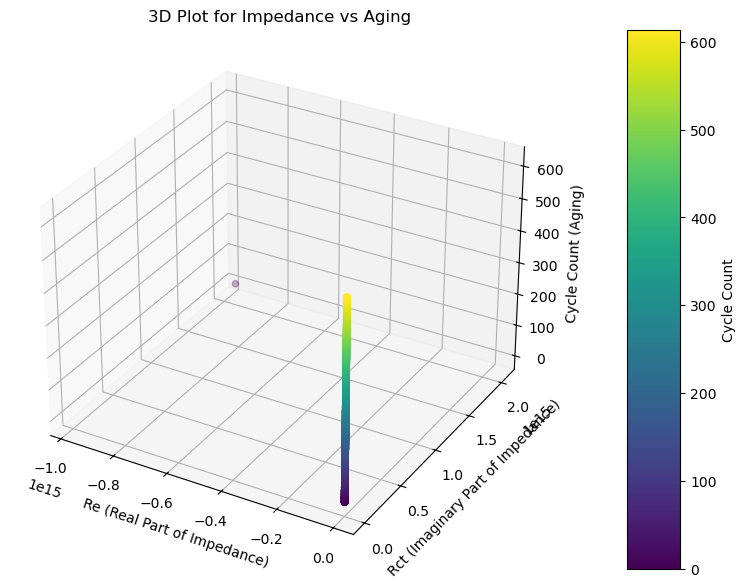

In [57]:
# part a
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

data = pd.read_csv('metadata.csv') 

#  Filter rows with valid impedance data (non-null 'Re' and 'Rct')
filtered_data = data.dropna(subset=['Re', 'Rct']).copy()

# Convert 'Re' and 'Rct' to numeric types (in case they are not already)
filtered_data['Re'] = pd.to_numeric(filtered_data['Re'], errors='coerce')
filtered_data['Rct'] = pd.to_numeric(filtered_data['Rct'], errors='coerce')

# Extract cycle count (or aging-related information)
# Using 'test_id' as a proxy for cycle count (assuming it correlates with cycles)
filtered_data['Cycle_Count'] = filtered_data['test_id']

# Plot the 3D impedance data
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for impedance data
sc = ax.scatter(
    filtered_data['Re'],              # Real part of impedance on X-axis
    filtered_data['Rct'],             # Imaginary part of impedance on Y-axis
    filtered_data['Cycle_Count'],     # Cycle count (aging) on Z-axis
    c=filtered_data['Cycle_Count'],   # Color by cycle count (aging)
    cmap='viridis', marker='o'
)

ax.set_xlabel('Re (Real Part of Impedance)')
ax.set_ylabel('Rct (Imaginary Part of Impedance)')
ax.set_zlabel('Cycle Count (Aging)')
ax.set_title('3D Plot for Impedance vs Aging')

cb = plt.colorbar(sc, ax=ax, pad=0.1, aspect=10)
cb.set_label('Cycle Count')

plt.show()


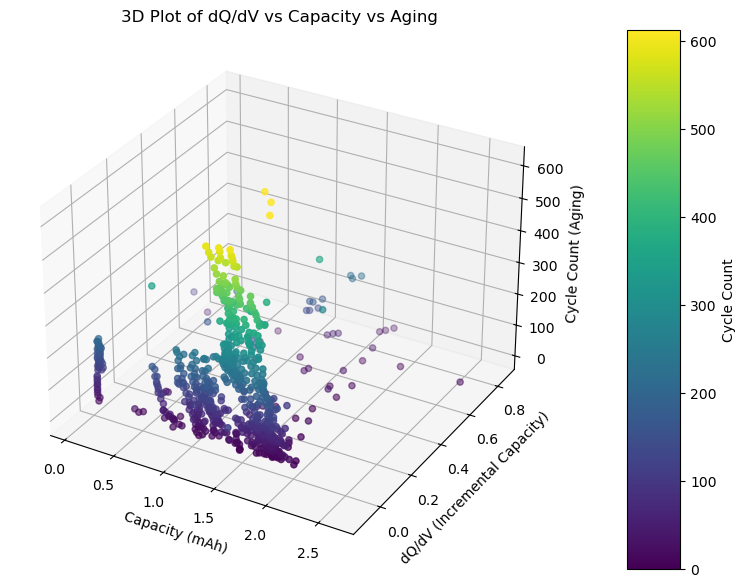

In [46]:
#part b
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from mpl_toolkits.mplot3d import Axes3D

data = pd.read_csv('metadata.csv') 

# Filter charge/discharge data (assuming 'type' column exists to indicate charge/discharge)
charge_discharge_data = data[data['type'].isin(['charge', 'discharge'])].dropna(subset=['Capacity'])

#  Ensure Capacity is numeric
charge_discharge_data['Capacity'] = pd.to_numeric(charge_discharge_data['Capacity'], errors='coerce')

# Calculate incremental capacity (dQ/dV) - gradient of Capacity
charge_discharge_data['dQ/dV'] = np.gradient(charge_discharge_data['Capacity'])

# Detect peaks in dQ/dV (representing significant events during charge/discharge)
peaks, _ = find_peaks(charge_discharge_data['dQ/dV'])

# Extract peak data (Capacity, dQ/dV, and Cycle Count from test_id)
peak_capacities = charge_discharge_data['Capacity'].iloc[peaks].values
peak_dQdV = charge_discharge_data['dQ/dV'].iloc[peaks].values
cycle_count = charge_discharge_data['test_id'].iloc[peaks].values  # Assuming 'test_id' represents the cycle count

peak_data = pd.DataFrame({
    'Capacity': peak_capacities,
    'dQ/dV': peak_dQdV,
    'Cycle_Count': cycle_count
})

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plotting the peaks (Capacity vs dQ/dV vs Cycle Count)
sc = ax.scatter(peak_data['Capacity'], peak_data['dQ/dV'], peak_data['Cycle_Count'], c=peak_data['Cycle_Count'], cmap='viridis', marker='o')

ax.set_xlabel('Capacity (mAh)')
ax.set_ylabel('dQ/dV (Incremental Capacity)')
ax.set_zlabel('Cycle Count (Aging)')
ax.set_title('3D Plot of dQ/dV vs Capacity vs Aging')
cb = plt.colorbar(sc, ax=ax, pad=0.1, aspect=10)
cb.set_label('Cycle Count')
plt.show()


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
Mean Squared Error (MSE): 1.2119
Mean Absolute Error (MAE): 0.8954
R-squared (R2): 0.9767
   Example Index                                           Features  \
0              0  {'Real Impedance (R(Z))': 77.19458621308237, '...   
1              1  {'Real Impedance (R(Z))': 97.8553714145801, 'I...   
2              2  {'Real Impedance (R(Z))': 8.54263781522748, 'I...   
3              3  {'Real Impedance (R(Z))': 29.04663258138005, '...   
4              4  {'Real Impedance (R(Z))': 108.90797687113117, ...   

   Actual Current Capacity  Predicted Current Capacity  Difference  
0                34.123634                   33.010536    1.113098  
1                29.129595                   27.925498    1.204097  
2                49.831942                   48.201632    1.630310  
3                43.178298                   43.299057   -0.120758 

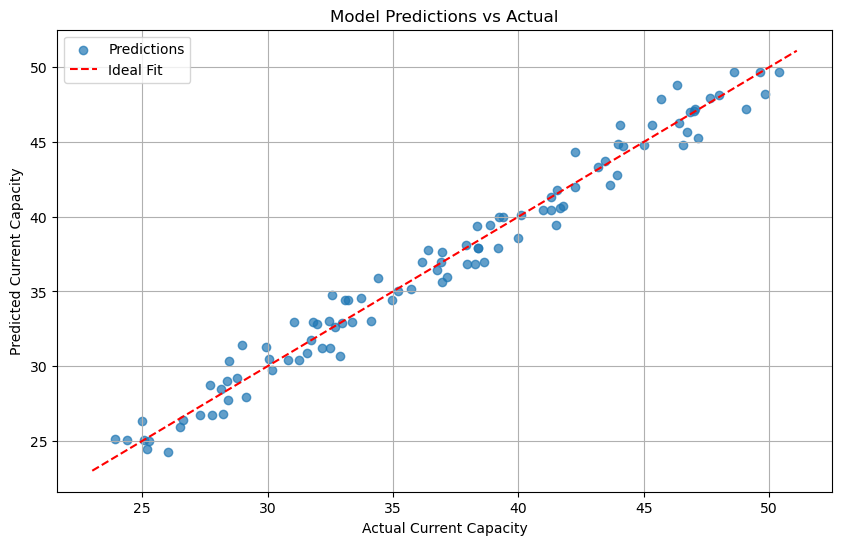

Model Evaluation (Full Test Set):
RMSE: 1.1009
MAE: 0.8954


In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Generate synthetic EIS signature data and current capacity for ML model
np.random.seed(42)
n_samples = 500
real_impedance = np.random.uniform(0, 120, n_samples)  # Simulated R(Z) in kΩ
imag_impedance = np.random.uniform(0, 40, n_samples)  # Simulated Im(Z) in kΩ
current_capacity = 50 - 0.2 * real_impedance - 0.1 * imag_impedance + np.random.normal(0, 1, n_samples)  # Simulated capacity

# Create a DataFrame for the dataset
data_ml = pd.DataFrame({
    "Real Impedance (R(Z))": real_impedance,
    "Imaginary Impedance (Im(Z))": imag_impedance,
    "Current Capacity": current_capacity
})

# Split the data into training and testing sets
X = data_ml[["Real Impedance (R(Z))", "Imaginary Impedance (Im(Z))"]]
y = data_ml["Current Capacity"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter tuning for Gradient Boosting Regressor
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}
gbr = GradientBoostingRegressor(random_state=42)
grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train)

# Best model from grid search
best_model = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

# Make predictions
y_pred = best_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R2): {r2:.4f}")

# Example predictions
example_results = []
for idx in range(min(5, len(X_test))):  # Up to 5 examples
    features = X_test.iloc[idx:idx+1]
    actual = y_test.iloc[idx]
    prediction = best_model.predict(features)[0]
    example_results.append({
        "Example Index": idx,
        "Features": features.iloc[0].to_dict(),
        "Actual Current Capacity": actual,
        "Predicted Current Capacity": prediction,
        "Difference": actual - prediction
    })

example_results_df = pd.DataFrame(example_results)
print(example_results_df)

# Plot true vs predicted capacities
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7, label="Predictions")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label="Ideal Fit")
plt.xlabel("Actual Current Capacity")
plt.ylabel("Predicted Current Capacity")
plt.title("Model Predictions vs Actual")
plt.legend()
plt.grid()
plt.show()

# Metrics
print("Model Evaluation (Full Test Set):")
print(f"RMSE: {np.sqrt(mse):.4f}")
print(f"MAE: {mae:.4f}")